In [16]:
import numpy as np
from filterpy.kalman import KalmanFilter
import matplotlib.pyplot as plt

In [17]:
from numpy.random import randn

class PosSensor(object):
    def __init__(self, pos=(0,0), vel=(0,0), noise_std=1.):
        self.vel = vel
        self.noise_std = noise_std
        self.pos = [pos[0], pos[1]]

    def read(self):
        self.pos[0] += self.vel[0]
        self.pos[1] += self.vel[1]

        return [self.pos[0] + randn() * self.noise_std, self.pos[1] + randn() * self.noise_std]

In [18]:
tracker = KalmanFilter(dim_x=4, dim_z=2)
dt = 1.0

# F:状態遷移関数の設計
tracker.F = np.array([[1, dt, 0, 0],
                      [0, 1, 0, 0],
                      [0, 0, 1, dt],
                      [0, 0, 0, 1],]
                    )

In [19]:
# Q:プロセスノイズ行列の設計
# Qが小さすぎるとフィルタが予測モデルに自身を持ちすぎる
# Qが大きすぎるとフィルタが観測値に加わるノイズから過度に影響を受け、振る舞いが最適でなくなる。
from scipy.linalg import block_diag
from filterpy.common import Q_discrete_white_noise

q = Q_discrete_white_noise(dim=2, dt=dt, var=0.001)
tracker.Q = block_diag(q, q)
print(tracker.Q)

[[0.00025 0.0005  0.      0.     ]
 [0.0005  0.001   0.      0.     ]
 [0.      0.      0.00025 0.0005 ]
 [0.      0.      0.0005  0.001  ]]


In [20]:
# B:制御関数の設計
tracker.B

In [21]:
# H:観測関数の設計
# 状態変数xから観測値zをz=Hxと計算する方法を与える
tracker.H = np.array([[1/0.3048, 0, 0, 0],
                      [0, 0, 1/0.3048, 0]])

In [22]:
# R:観測ノイズ行列の設計
tracker.R = np.array([[5.0, 0],
                     [0.0, 5.0]])

In [23]:
# 初期条件
# x:初期位置
# P:推定値の共分散行列
tracker.x = np.array([[0, 0, 0, 0]]).T
tracker.P = np.eye(4) * 500

In [24]:
R_std = 0.35
Q_std = 0.04

def tracker1():
    tracker = KalmanFilter(dim_x=4, dim_z=2)
    dt = 1.0   # time step

    tracker.F = np.array([[1, dt, 0,  0],
                          [0,  1, 0,  0],
                          [0,  0, 1, dt],
                          [0,  0, 0,  1]])
    tracker.u = 0.
    tracker.H = np.array([[1/0.3048, 0, 0, 0],
                          [0, 0, 1/0.3048, 0]])

    tracker.R = np.eye(2) * R_std**2
    q = Q_discrete_white_noise(dim=2, dt=dt, var=Q_std**2)
    tracker.Q = block_diag(q, q)
    tracker.x = np.array([[0, 0, 0, 0]]).T
    tracker.P = np.eye(4) * 500.
    return tracker

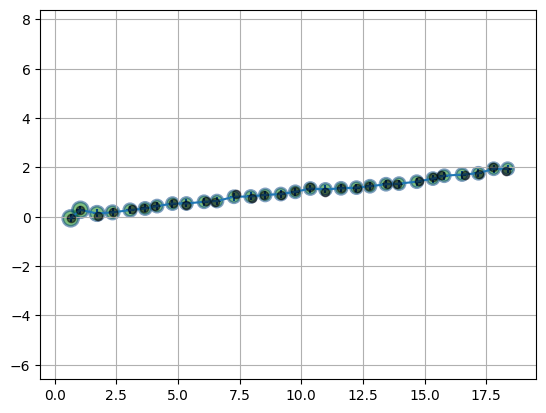

In [31]:
from filterpy.stats import plot_covariance_ellipse

# ロボットの移動のシミュレート
N = 30
sensor = PosSensor((0, 0), (2, .2), noise_std=R_std)

zs = np.array([sensor.read() for _ in range(N)])

# フィルタの実行
robot_tracker = tracker1()
mu, cov, _, _ = robot_tracker.batch_filter(zs)

fig = plt.figure()
ax = fig.add_subplot(111)
for x, P in zip(mu, cov):
    # xとyの共分散
    cov = np.array([[P[0, 0], P[2, 0]],
                    [P[0, 2], P[2, 2]]])
    mean = (x[0, 0], x[2, 0])
    plot_covariance_ellipse(mean, cov=cov, fc='g', std=3, alpha=0.5)

zs *= .3048
ax.plot(mu[:, 0], mu[:, 2])
ax.plot(zs[:, 0], zs[:, 1], 'ko', alpha=0.5)
ax.grid()